In [14]:
from pandas import read_csv

def read_data(file_path, num_features = 2, have_time = False):
    series_influ_A_df = read_csv(file_path, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

    # because since 2011-03-01 It was announced that the H1N12009 flu had been controlled and treated as regular seasonal flu and
    # since 2020-02-01, it's time for covid 
    
    series_influ_A_df = series_influ_A_df.loc [(series_influ_A_df['Month'] >='2011-04-01') & (series_influ_A_df['Month'] <='2020-02-01')]
    if not have_time:
        return series_influ_A_df.dropna()[["case", "temp", "dew", "tempmax", "humidity","tempmin","windspeed"][:num_features]]
    return series_influ_A_df.dropna()[["Month", "case", "temp", "dew", "tempmax", "humidity","tempmin","windspeed"][:num_features+1]]

file_path = '../temp_data/influA_vietnam_temp_month.csv'
#Load data set
df = read_data(file_path, have_time=True)



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

def calculate_errors(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Root Mean Squared Percentage Error (RMSPE)
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
    
    # Mean Absolute Residual (MARE)
    mare = np.mean(np.abs(y_true - y_pred))
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # Normalized Nash-Sutcliffe Efficiency (NNSE)
    nnse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((np.abs(y_true - np.mean(y_true)) + np.abs(y_pred - np.mean(y_true))) ** 2))
    
    return mae, mse, rmse, mape, rmspe, mare, nse, nnse

In [16]:
def plot_r2(x,y, file_path=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    # r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Print error metrics
    mae, mse, rmse, mape, rmspe, mare, nse, nnse = calculate_errors(x, y)
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSPE: {rmspe:.2f}%')
    print(f'MARE: {mare:.2f}')
    print(f'NSE: {nse:.2f}')
    print(f'NNSE: {nnse:.2f}')

    # Create the scatter plot
    plt.figure(figsize=(10, 12))

    # Subplot 1: Scatter plot and regression line
    plt.subplot(3, 1, 1)
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, r2_line, color='red', marker="o", label=f'Regression line')
    plt.title('Correlation ')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title(f'Scatter Plot with R-squared Line\nCorrelation: {r_value:.2f}, R^2: {r2_pearson:.2f}')
    plt.legend()
    plt.grid()

    # Subplot 2: Real values over time
    plt.subplot(3, 1, 2)
    plt.plot( x, color='blue', label='Real_values')
    plt.xlabel('Time')
    plt.ylabel('Real_values')
    plt.title('Real Values over Time')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Forecast values over time
    plt.subplot(3, 1, 3)
    plt.plot(y, color='green', label='Forecast_values')
    plt.xlabel('Time')
    plt.ylabel('Forecast_values')
    plt.title('Forecast Values over Time')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # plt.savefig(file_path)
    # plt.close()
    plt.show()

In [17]:
df = df[["Month", "case"]]
new_df = df.set_index(keys="Month")

In [18]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
# import numpy as np
# def calculate_err(y_true, y_pred):
#     # Mean Squared Error (MSE)
#     mse = mean_squared_error(y_true, y_pred)
#     # Root Mean Squared Error (RMSE)
#     rmse = np.sqrt(mse)
#     return mse, rmse

In [19]:

# season_fc_np = season_fc_df['case'].to_numpy()
# test_np = test['case'].to_numpy()
# season_mse, season_rmse = calculate_err(test_np, season_fc_np)
# print("MSE: ", season_mse, "RMSE: ", season_rmse)


In [20]:
import numpy as np

def remove_outlier_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    upper = df[~(df>(q3+1.5*IQR))].max()

    lower = df[~(df<(q1-1.5*IQR))].min()

    df = np.where(
        df > upper,
        np.nan,
        np.where(df < lower,np.nan,df)
        )
    return df

def remove_outlier_impute(df, impute_method= 'linear'):
    output_df = df.copy()
    if impute_method != "raw":
        output_df["case"] = remove_outlier_IQR(output_df['case'])
        match impute_method:
            case 'linear':
                output_df['case'] = output_df['case'].interpolate(method='linear')
            case 'spline':
                output_df['case'] = output_df['case'].interpolate(method='spline', order=3)
            case _:
                pass
    return output_df

In [21]:
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()
# window_size = 2

def preprocessing(df, window_size, method, is_smooth):
    import pandas as pd
    df_ = pd.DataFrame()
    df_ = df.copy()
    is_ma, is_ema = is_smooth
    df_ = remove_outlier_impute(df_, method)
    if is_ema:
        # Apply Moving Average Filter
        
        df_['case'] = exponential_moving_average(df_['case'], window_size)
        df_ = df_.dropna()
    if is_ma:
        # Apply Moving Average Filter
        
        df_['case'] = moving_average(df_['case'], window_size)
        df_ = df_.dropna()
    return df_

# linear_df = remove_outlier_impute(new_df.reset_index(), 'linear').set_index(keys='Month')
# spline_df = remove_outlier_impute(new_df.reset_index(), 'spline').set_index(keys='Month')

linear_ma_df = preprocessing(new_df.reset_index(), 2, 'linear', [True, False]).set_index(keys='Month')
linear_ema_df = preprocessing(new_df.reset_index(), 2, 'linear', [False, True]).set_index(keys='Month')
spline_ma_df = preprocessing(new_df.reset_index(), 2, 'spline', [True, False]).set_index(keys='Month')
spline_ema_df = preprocessing(new_df.reset_index(), 2, 'linear', [False, True]).set_index(keys='Month')

def split_train_test(df):
    num_predict = 8
    look_back = 8
    test_size = num_predict
    length = len(df)
    dataset_length = length - (length -look_back) % num_predict
    rest = length - dataset_length
    dataset = df.iloc[rest:]
    train = dataset.iloc[: -test_size]
    test = dataset.iloc[-test_size:]

    return train,test

train, test = split_train_test(linear_ma_df)



In [22]:
from utils import adf_test, check_acorr_ljungbox
adf_test(train)
check_acorr_ljungbox(train, lags=10)

Results of Dickey-Fuller Test:
Test Statistic                 -5.405069
p-value                         0.000035
#Lags Used                      5.000000
Number of Observations Used    90.000000
Critical Value (1%)            -4.063054
Critical Value (5%)            -3.460450
Critical Value (10%)           -3.156294
dtype: float64
       lb_stat     lb_pvalue
1    61.118052  5.375300e-15
2    76.740172  2.168120e-17
3    77.172262  1.240078e-16
4    81.141172  9.981702e-17
5    94.514721  7.553837e-19
6   112.020634  7.691993e-22
7   125.412858  5.702005e-24
8   129.995196  2.835548e-24
9   130.039925  1.163726e-23
10  131.518817  2.288161e-23
Có tự tương quan với lag 1
Có tự tương quan với lag 2
Có tự tương quan với lag 3
Có tự tương quan với lag 4
Có tự tương quan với lag 5
Có tự tương quan với lag 6
Có tự tương quan với lag 7
Có tự tương quan với lag 8
Có tự tương quan với lag 9
Có tự tương quan với lag 10


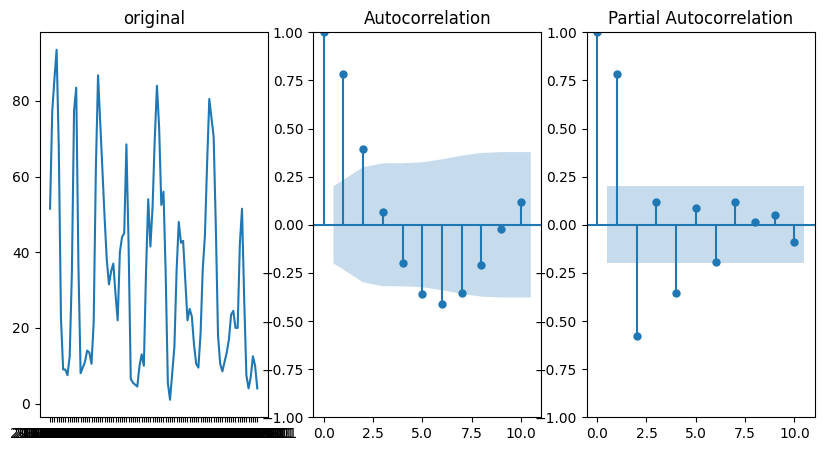

In [23]:
# Original Series
import statsmodels.api as sm
import matplotlib.pyplot as plt

# PACF plot of 1st differenced series
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 3, figsize=(10,5))
axes[0].plot(train); axes[0].set_title('original')
# axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_acf(train.dropna(), ax=axes[1], lags=10)
sm.graphics.tsa.plot_pacf(train.dropna(), ax=axes[2], lags=10)

plt.show()

In [24]:
# How to build the ARIMA Model 

import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=10, # maximum p and q
                      # m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      trend='c',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
# chọn được p,d,q là 2,0,2

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=893.066, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=800.645, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=760.908, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=760.859, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=745.672, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=745.672, Time=0.11 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 0.754 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -366.836
Date:    

In [25]:
# from statsmodels.tsa.arima.model import ARIMA

# def find_model_arima(orders, data):
#   # model = ARIMA(train, order=(2,0,1))

#   # # dùng lbfgs để ước lượng tham số maximum likelyhood
#   # model_fit = model.fit()
#   # print(model_fit.summary())
#   models = []
#   for order in orders:
#     a={}
#     model = ARIMA(data, order = order).fit()
#     model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
#     # print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
#     a["name"] = model_name
#     a["aic"] = model.aic
#     a["bic"] = model.bic
#     models.append(a)
#   return models
# orders = [(1,0,2), (1,0,3), (2,0,2),(2,0,3), (2,0,1), (1,0,1)]
# models = find_model_arima(orders, train)
# for model in models:
#    print('{} --> AIC={}; BIC={}'.format(model["name"], model["aic"], model["bic"]))

In [26]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(4,0,0), trend='c')

# dùng lbfgs để ước lượng tham số maximum likelyhood
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   case   No. Observations:                   96
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -366.836
Date:                Sun, 30 Jun 2024   AIC                            745.672
Time:                        13:22:15   BIC                            761.059
Sample:                    07-01-2011   HQIC                           751.892
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9456      3.305      9.968      0.000      26.467      39.424
ar.L1          1.4157      0.095     14.956      0.000       1.230       1.601
ar.L2         -1.1169      0.164     -6.826      0.0

d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


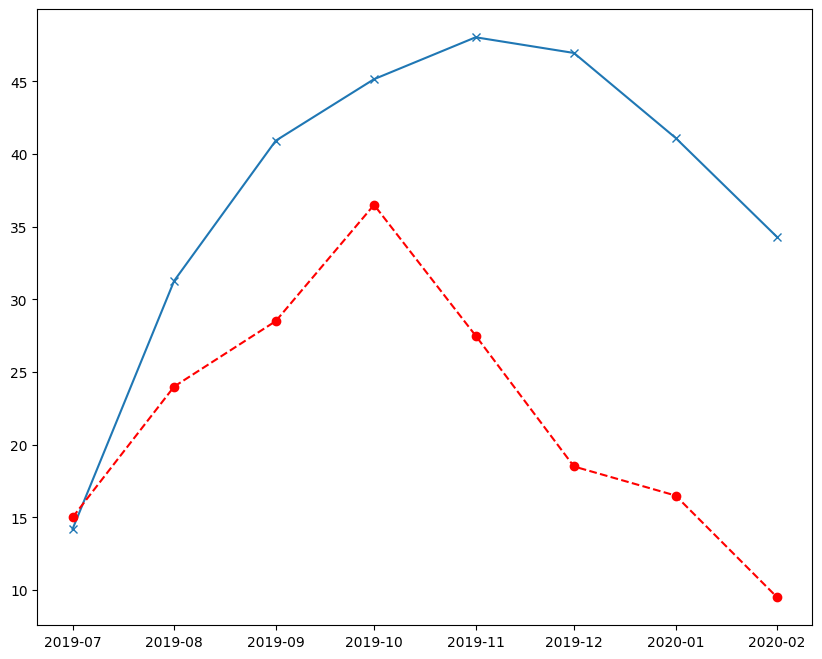

In [27]:
import pandas as pd
fc = model_fit.forecast(len(test), alpha=0.05)
fc_df = pd.DataFrame(fc).reset_index().rename(columns={'index': 'Month', 'predicted_mean': 'case'})
# test_df =  pd.DataFrame(test).reset_index()
# fc_df["Month"] = test_df["Month"]
plt.figure(figsize=(10,8))
plt.plot(fc_df['Month'], fc_df['case'], label='Actual', marker='x')
plt.plot(fc_df['Month'], test['case'], color='red', linestyle='--', label='Forecast', marker='o')
plt.show()

MAE: 15.94
MSE: 341.70
RMSE: 18.49
MAPE: 92.68%
RMSPE: 123.97%
MARE: 15.94
NSE: -4.11
NNSE: 0.50


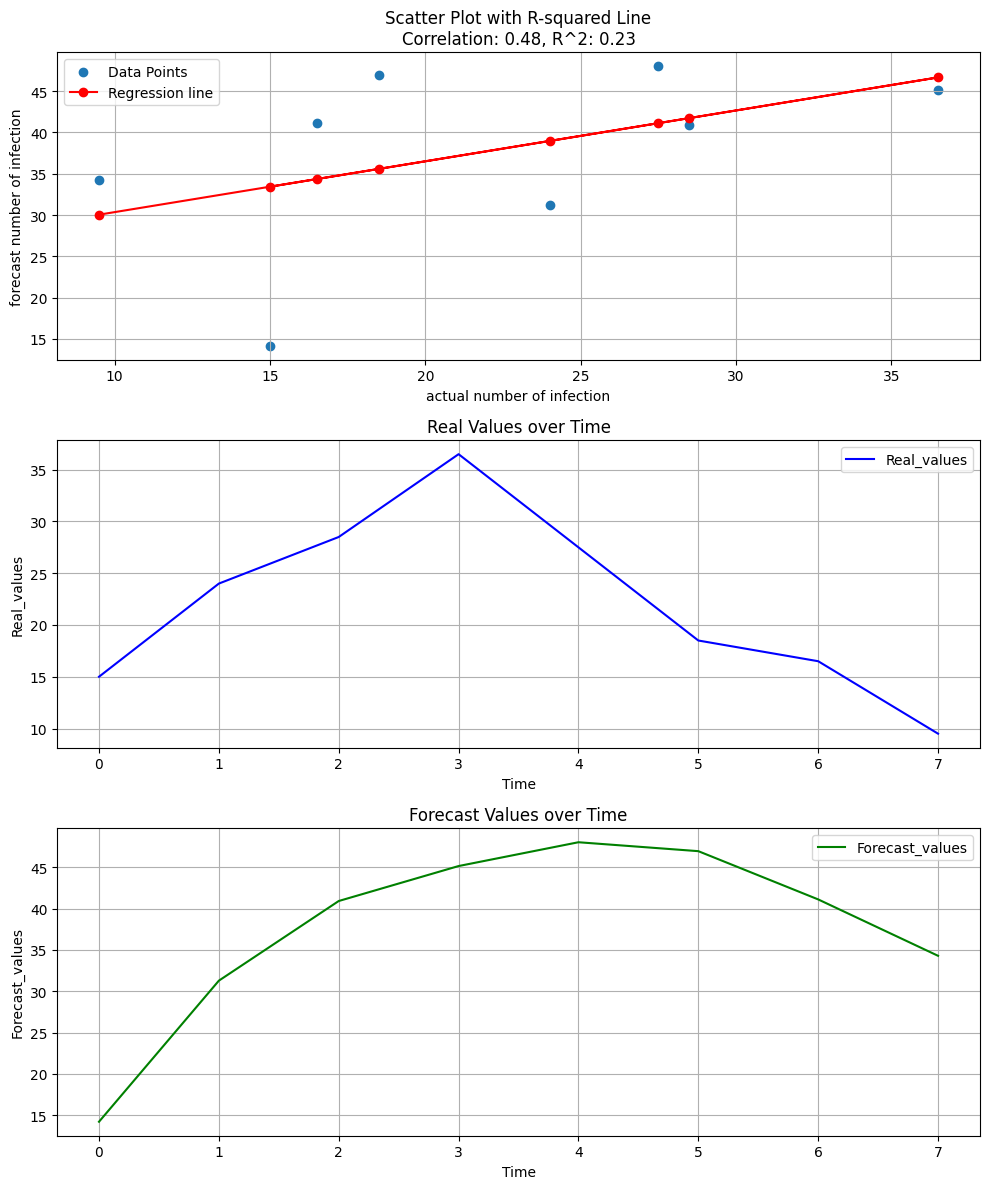

In [28]:
plot_r2(test['case'].values, fc_df['case'].values)

## Seasonal

In [29]:
linear_ma_df_season = linear_ma_df.diff(periods=12).dropna()

In [30]:
train_season, test_season = split_train_test(linear_ma_df_season)
adf_test(train_season)
check_acorr_ljungbox(train_season, lags=10)

Results of Dickey-Fuller Test:
Test Statistic                 -5.452950
p-value                         0.000029
#Lags Used                     10.000000
Number of Observations Used    69.000000
Critical Value (1%)            -4.096354
Critical Value (5%)            -3.476155
Critical Value (10%)           -3.165415
dtype: float64
      lb_stat     lb_pvalue
1   45.641171  1.420248e-11
2   60.736114  6.476204e-14
3   68.035370  1.124250e-14
4   70.097960  2.164284e-14
5   70.103344  9.752778e-14
6   70.418558  3.355408e-13
7   70.861948  9.891062e-13
8   73.542787  9.652788e-13
9   81.185023  9.395688e-14
10  96.009220  3.417536e-16
Có tự tương quan với lag 1
Có tự tương quan với lag 2
Có tự tương quan với lag 3
Có tự tương quan với lag 4
Có tự tương quan với lag 5
Có tự tương quan với lag 6
Có tự tương quan với lag 7
Có tự tương quan với lag 8
Có tự tương quan với lag 9
Có tự tương quan với lag 10


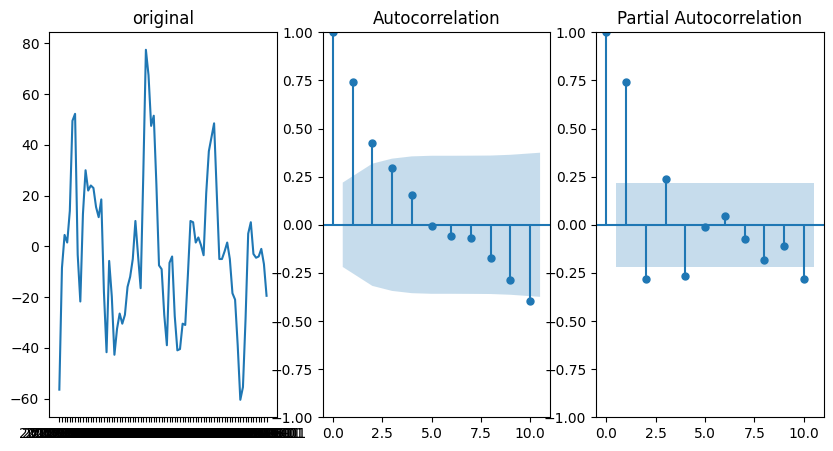

In [31]:
# Original Series
import statsmodels.api as sm
import matplotlib.pyplot as plt

# PACF plot of 1st differenced series
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 3, figsize=(10,5))
axes[0].plot(train_season); axes[0].set_title('original')
# axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_acf(train_season.dropna(), ax=axes[1], lags=10)
sm.graphics.tsa.plot_pacf(train_season.dropna(), ax=axes[2], lags=10)

plt.show()

In [32]:
# How to build the ARIMA Model 

import pmdarima as pm

model_sarima = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=10, # maximum p and q
                      m=12,
                      # m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      D=0, start_P=0, max_P=3, 
                    #   trend='c',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
# chọn được p,d,q là 2,0,2

print(model_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=893.066, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=801.616, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=991.292, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=800.645, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=801.982, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=760.908, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=762.552, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=762.654, Time=0.20 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[12]             : AIC=782.868, Time=

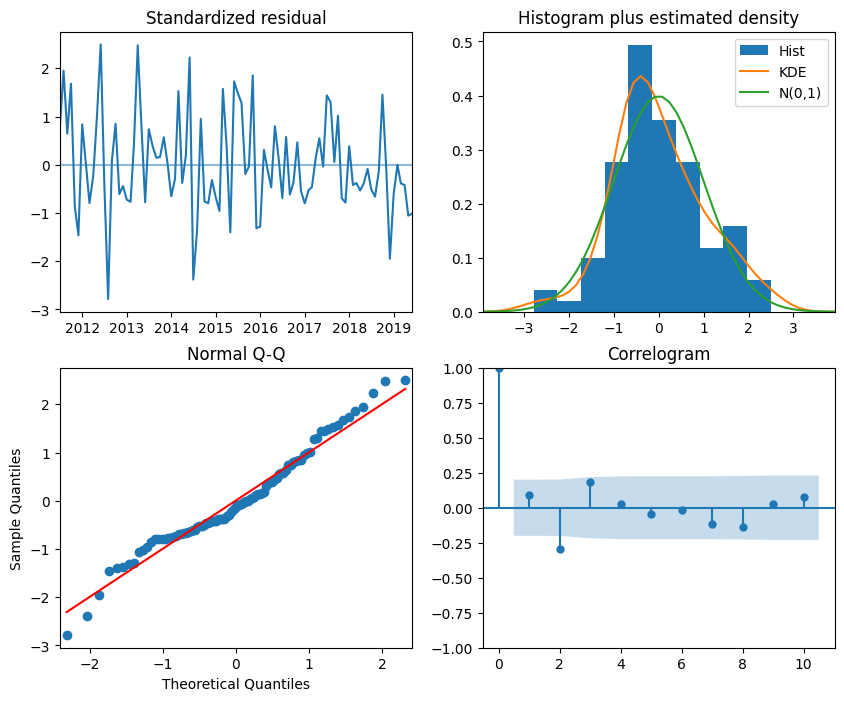

In [33]:
model_sarima.plot_diagnostics(figsize=(10,8))
plt.show()

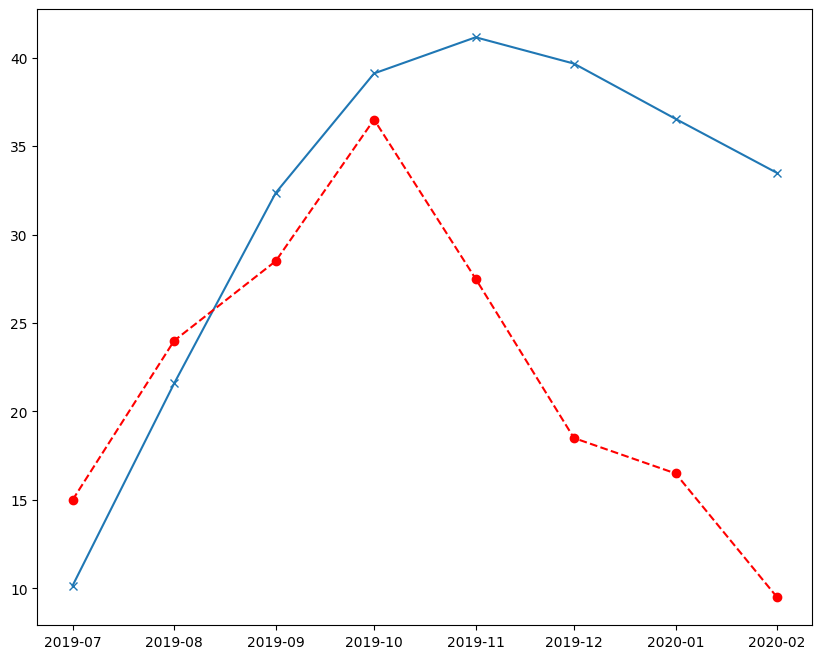

In [34]:
season_fc = model_sarima.predict(n_periods=len(test), alpha=0.05)
season_fc_df = pd.DataFrame(season_fc).reset_index().rename(columns={'index': 'Month', 0: 'case'})
plt.figure(figsize=(10,8))
plt.plot(season_fc_df['Month'], season_fc_df['case'], label='Actual', marker='x')
plt.plot(season_fc_df['Month'], test['case'], color='red', linestyle='--', label='Forecast', marker='o')
plt.show()


MAE: 11.57
MSE: 207.69
RMSE: 14.41
MAPE: 75.11%
RMSPE: 109.19%
MARE: 11.57
NSE: -2.11
NNSE: 0.55


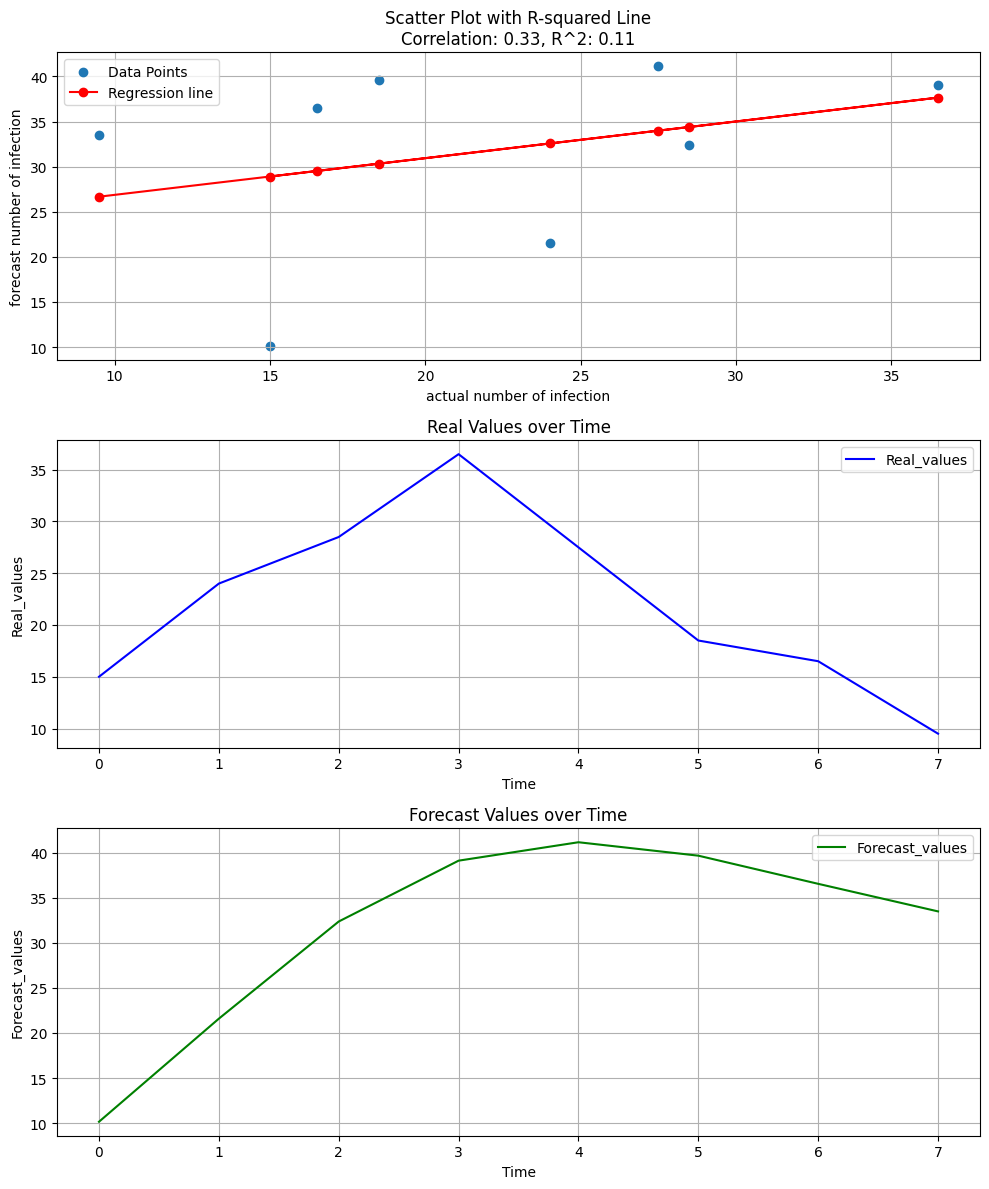

In [35]:
plot_r2(test['case'].values, season_fc_df['case'].values)

In [36]:
model = ARIMA(train, order=(4,0,0), seasonal_order=(0,0,0,12), trend='c')

# dùng lbfgs để ước lượng tham số maximum likelyhood
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   case   No. Observations:                   96
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -366.836
Date:                Sun, 30 Jun 2024   AIC                            745.672
Time:                        13:22:20   BIC                            761.059
Sample:                    07-01-2011   HQIC                           751.892
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9456      3.305      9.968      0.000      26.467      39.424
ar.L1          1.4157      0.095     14.956      0.000       1.230       1.601
ar.L2         -1.1169      0.164     -6.826      0.0

d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
